In [2]:
%cd /home/ltchen/gnnpp
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils import to_networkx
from scipy.interpolate import interp1d
from utils.data import load_dataframes, load_distances, load_stations, dist_km, compute_dist_matrix, normalize_features_and_create_graphs, split_graph, shuffle_features, summary_statistics, get_mask, generate_layers, create_multigraph
from tqdm import tqdm
from utils.plot import plot_map
from torch_geometric.utils import is_undirected, degree, contains_isolated_nodes
from exploration.graph_creation import *

/home/ltchen/gnnpp


In [45]:
dataframes = load_dataframes(mode="eval", leadtime= "24h") # load newly created dataframes
# dataframes = summary_statistics(dataframes)

train = dataframes["train"][0]
train_target = dataframes["train"][1]
test_rf = dataframes["test_rf"][0]
test_rf_target = dataframes["test_rf"][1]
test_f = dataframes["test_f"][0]
test_f_target = dataframes["test_f"][1]
stations = dataframes["stations"]



[INFO] Dataframes exist. Will load pandas dataframes.


In [19]:
train.groupby(["time", "station_id"]).mean()["t2m"]

time        station_id
1997-01-02  0             279.183807
            1             278.898285
            2             278.370850
            3             277.342896
            4             278.731567
                             ...    
2013-12-31  117           279.406189
            118           276.338898
            119           273.782959
            120           270.572021
            121           268.595978
Name: t2m, Length: 420656, dtype: float32

In [20]:
train[train["station_id"] == 62].groupby(["time", "station_id"]).mean()["t2m"]

time        station_id
1997-01-02  62            277.574585
1997-01-05  62            276.621948
1997-01-09  62            277.838745
1997-01-12  62            276.268707
1997-01-16  62            270.084106
                             ...    
2013-12-24  62            276.690155
2013-12-25  62            273.750122
2013-12-27  62            276.239288
2013-12-28  62            271.843201
2013-12-31  62            275.485107
Name: t2m, Length: 3448, dtype: float32

In [44]:
stations.iloc[73]

station_id                5100
lat                    49.7479
lon                     6.6583
altitude                 265.0
orog                365.289857
name          Trier-Petrisberg
Name: 73, dtype: object

In [33]:
print(f"Number of NaN in t2m of station 62: \n{train_target[train_target['station_id'] == 62].isna().sum()}")
print(f"Number of total values of station 62: {train_target[train_target['station_id'] == 62].shape[0]}\n")

print(f"Number of NaN in t2m of station 74: \n{train_target[train_target['station_id'] == 74].isna().sum()}")
print(f"Number of total values of station 74: {train_target[train_target['station_id'] == 74].shape[0]}")

Number of NaN in t2m of station 62: 
time             0
station_id       0
t2m           3448
dtype: int64
Number of total values of station 62: 3448

Number of NaN in t2m of station 74: 
time             0
station_id       0
t2m           3448
dtype: int64
Number of total values of station 74: 3448


In [49]:
d2mat = load_d2_distances(stations, train)

[INFO] Loading distances from file...


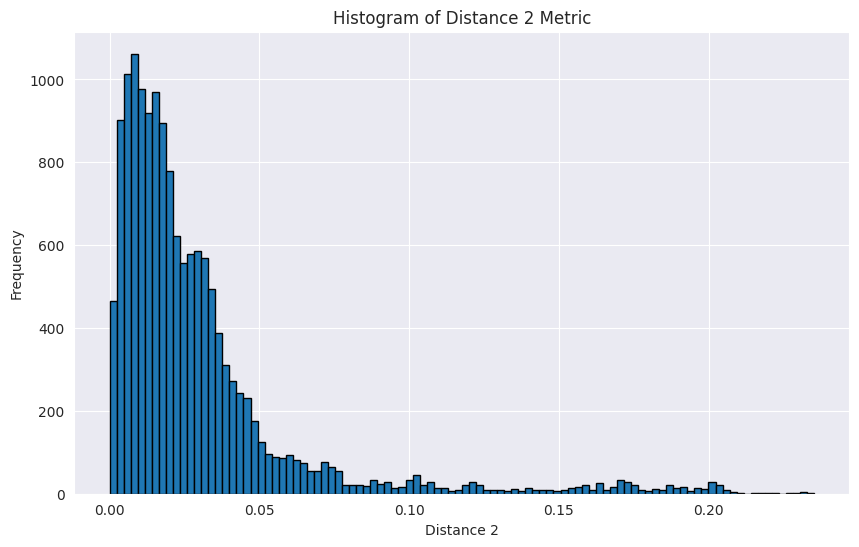

In [55]:
# rounded = np.round(d3mat.flatten())
rounded2 = d2mat.flatten()
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(rounded2, bins=100, edgecolor='black')
plt.title('Histogram of Distance 2 Metric')
plt.xlabel('Distance 2')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [51]:
d3mat = load_d3_distances(stations, train, train_target)

[INFO] Loading distances from file...


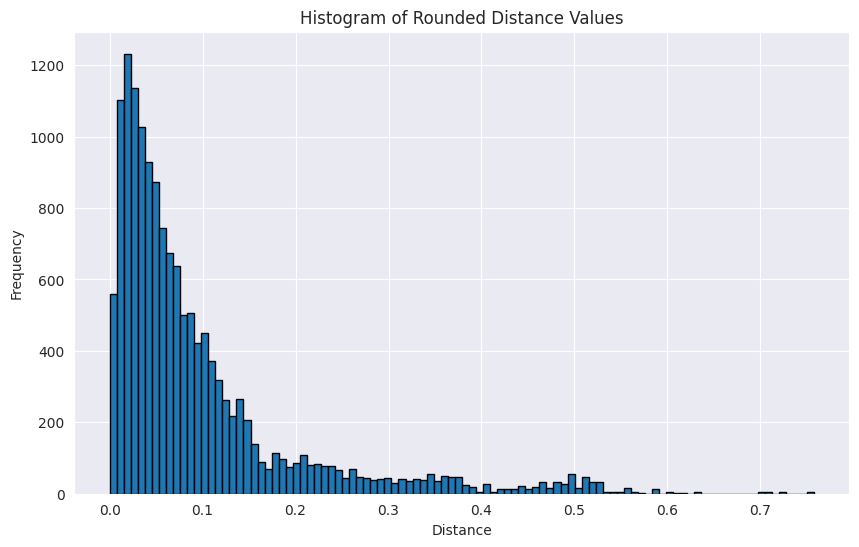

In [56]:
rounded3 = d3mat.flatten()
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(rounded3, bins=100, edgecolor='black')
plt.title('Histogram of Rounded Distance Values')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [15]:
np.unravel_index(np.argmax(d3mat), d3mat.shape)

(62, 119)

In [17]:
# check if get_emp_cdf works
id = 62
S = np.arange(-30,30, 1)
i_train = train[train['station_id'] == id]
i_target_temps = train_target[train_target['station_id'] == id]['t2m']
print(i_train.shape)
print(i_target_temps.shape)
print(S.shape)
# cdf_values = np.zeros(S.shape)
# for idx, x in enumerate(S):
#     value = create_emp_cdf_of_errors(i_train, i_target_temps)(x)
#     cdf_values[idx] = value
# print(cdf_values)
# print(cdf_values.shape)

cdfs = []

for i_id in range(0, 122):
    i_train = train[train['station_id'] == i_id]
    i_target_temps = train_target[train_target['station_id'] == i_id]['t2m']
    G_s = create_emp_cdf_of_errors(i_train, i_target_temps)
    cdfs.append(G_s)
list_of_all_G_i_values = []
for G_i in tqdm(cdfs):
    cdf_values = np.zeros(S.shape)
    for idx, x in enumerate(S):
        cdf_values[idx] = G_i(x)
    # print(cdf_values)
    list_of_all_G_i_values.append(cdf_values)
    # print(len(list_of_all_G_i_values))


print(all(f is cdfs[0] for f in cdfs))

# plt.figure(figsize=(8, 4))
# plt.step(S.T, cdf_values, where='post', label='Empirical CDF')
# plt.title('Empirical CDF of Forecast Errors')
# plt.xlabel('Error')
# plt.ylabel('CDF')
# plt.grid(True)
# plt.legend()
# plt.show()

(37928, 36)
(3448,)
(60,)


100%|██████████| 122/122 [02:58<00:00,  1.46s/it]

False


In [ ]:
all(np.array_equal(list_of_all_G_i_values[0], arr) for arr in list_of_all_G_i_values)
# print(list_of_all_G_i_values)
print(np.sort(d3mat))
print(np.argsort(d3mat))


In [ ]:
plt.figure(figsize=(8, 4))
plt.step(S.T, list_of_all_G_i_values[119], where='post', label='Empirical CDF')
plt.title('Empirical CDF of Forecast Errors')
plt.xlabel('Error')
plt.ylabel('CDF')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
for idx, array in enumerate(list_of_all_G_i_values):
    if np.all(array == 0):
        print(idx)


In [ ]:
graphs_train_rf, tests = normalize_features_and_create_graphs1(df_train=dataframes['train'], df_valid_test=[dataframes['test_rf'], dataframes['test_f']], station_df=dataframes['stations'], attributes=["geo", "alt", "lon", "lat", "dist2"], edges=[("geo", 100)], sum_stats = True)

graphs_test_rf, graphs_test_f = tests
graphs_test = graphs_test_rf